# Algorithm Search

Initial exploration of NSQIP processed data and readmission classification potential using a variety of different ML approaches

In [1]:
import sys
import pandas as pd
import numpy as np

# Define a random seed for reproducibility
seed = 0
np.random.seed(seed)

import sklearn
import xgboost
import keras
import tensorflow as tf

print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('XGBoost: {}'.format(xgboost.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.3
Numpy: 1.18.1
Sklearn: 0.22.1
XGBoost: 1.1.1
Keras: 2.3.1


In [5]:
# import the processed dataset
df = pd.read_csv('../data/processed/NSQIP_Clean2.csv')

In [6]:
# Describe the dataset
from IPython.display import HTML
HTML(pd.DataFrame(df.describe()).to_html())

,Unnamed: 0,index,READMISSION1,SMOKE,HXCOPD,HYPERMED,DISCANCR,WNDINF,STEROID,WTLOSS,EMERGNCY,RETURNOR,BLEEDIS_0.0,BLEEDIS_1.0,BLEEDIS_2.0,DIABETES,DYSPNEA,PRSEPIS,ASACLAS,SEX_female,SEX_male,RACE_American Indian or Alaska Native,RACE_Asian,RACE_Black or African American,RACE_Native Hawaiian or Pacific Islander,RACE_Unknown/Not Reported,RACE_White,HISPANIC_N,HISPANIC_U,HISPANIC_Y,TRAN_From acute care hospital inpatient,TRAN_Not transferred (admitted from home),TRAN_Nursing home - Chronic care - Intermediate care,TRAN_Outside emergency department,TRAN_Transfer from other,DISCHDEST_Home,DISCHDEST_Rehab,"DISCHDEST_Skilled Care, Not Home",DISCHDEST_Unknown,index.1,AGE,WEIGHT,PUFYEAR,OPTIME,TOTHLOS,PRSODM,PRBUN,PRCREAT,PRALBUM,PRPLATE,PRPTT,PRINR,PRPT
count,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1533.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,924.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000
mean,1004.790091,1004.790091,0.095828,0.132334,0.019557,0.451108,0.018905,0.001956,0.110169,0.011734,0.022816,0.043677,0.597132,0.005215,0.397653,0.184485,0.033898,0.011082,0.647913,0.498044,0.501956,0.003259,0.075619,0.139505,0.003259,0.144068,0.629726,0.426988,0.078227,0.097132,0.018905,0.954368,0.005215,0.016949,0.003259,0.940678,0.023468,0.016949,0.001956,1004.790091,-0.027159,-0.012939,0.278780,0.039475,0.014680,0.040770,0.045461,0.049931,0.018751,0.038299,0.019667,0.057454,-0.310162
std,445.941986,445.941986,0.294451,0.338964,0.138516,0.497766,0.136233,0.044194,0.313203,0.107721,0.149366,0.204441,0.490635,0.072051,0.489573,0.388006,0.181026,0.104721,0.157283,0.500159,0.500159,0.057017,0.264474,0.346585,0.057017,0.351273,0.483035,0.494802,0.268616,0.296234,0.136233,0.208754,0.072051,0.129123,0.057017,0.236303,0.151434,0.129123,0.044194,445.941986,1.002493,0.996155,0.586997,1.049078,0.951713,0.931274,0.942819,0.920126,1.003420,0.947258,0.994932,0.966301,0.562898
min,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-2.220814,-5.202635,-0.702101,-1.683243,-11.505392,-3.517534,-2.568833,-3.325918,-0.839085,-2.845054,-1.330860,-1.696501,-0.429450
25%,622.250000,622.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,622.250000,-0.772417,-0.610939,-0.357072,-0.613731,-0.279138,0.243796,0.234812,0.293387,-0.839085,-0.240962,-1.330860,0.586251,-0.429450
50%,1005.500000,1005.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1005.500000,0.109216,-0.098789,0.332986,-0.215285,-0.167987,0.275672,0.337698,0.297743,-0.839085,0.146222,0.694512,0.588994,-0.429450
75%,1390.750000,1390.750000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,

In [7]:
data = df
data = data.drop(columns=['index.1', 'index', 'Unnamed: 0']).copy()
# Replace missing values with median values
data['AGE'].replace(np.NaN, data['AGE'].median(), inplace=True)
data = data.dropna()
HTML(pd.DataFrame(data.describe()).to_html())

,READMISSION1,SMOKE,HXCOPD,HYPERMED,DISCANCR,WNDINF,STEROID,WTLOSS,EMERGNCY,RETURNOR,BLEEDIS_0.0,BLEEDIS_1.0,BLEEDIS_2.0,DIABETES,DYSPNEA,PRSEPIS,ASACLAS,SEX_female,SEX_male,RACE_American Indian or Alaska Native,RACE_Asian,RACE_Black or African American,RACE_Native Hawaiian or Pacific Islander,RACE_Unknown/Not Reported,RACE_White,HISPANIC_N,HISPANIC_U,HISPANIC_Y,TRAN_From acute care hospital inpatient,TRAN_Not transferred (admitted from home),TRAN_Nursing home - Chronic care - Intermediate care,TRAN_Outside emergency department,TRAN_Transfer from other,DISCHDEST_Home,DISCHDEST_Rehab,"DISCHDEST_Skilled Care, Not Home",DISCHDEST_Unknown,AGE,WEIGHT,PUFYEAR,OPTIME,TOTHLOS,PRSODM,PRBUN,PRCREAT,PRALBUM,PRPLATE,PRPTT,PRINR,PRPT
count,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000
mean,0.095238,0.132420,0.019569,0.450750,0.018917,0.001957,0.110241,0.011742,0.022831,0.043705,0.596869,0.005219,0.397913,0.183953,0.033920,0.011089,0.647913,0.497717,0.502283,0.003262,0.075669,0.139596,0.003262,0.144162,0.629485,0.427267,0.078278,0.096543,0.018917,0.954338,0.005219,0.016960,0.003262,0.941292,0.023483,0.016308,0.001957,0.026155,-0.012054,0.278520,0.040004,0.013494,0.040544,0.045120,0.049754,0.017983,0.038107,0.020548,0.058598,-0.310085
std,0.293639,0.339058,0.138561,0.497731,0.136277,0.044209,0.313293,0.107756,0.149413,0.204505,0.490687,0.072074,0.489627,0.387572,0.181083,0.104755,0.157283,0.500158,0.500158,0.057036,0.264553,0.346680,0.057036,0.351368,0.483100,0.494843,0.268696,0.295430,0.136277,0.208819,0.072074,0.129164,0.057036,0.235155,0.151482,0.126698,0.044209,0.780166,0.995876,0.587100,1.049216,0.950889,0.931535,0.943032,0.920401,1.003296,0.947537,0.994657,0.965576,0.563074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.220814,-5.202635,-0.702101,-1.683243,-11.505392,-3.517534,-2.568833,-3.325918,-0.839085,-2.845054,-1.330860,-1.696501,-0.429450
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.142679,-0.610939,-0.357072,-0.613731,-0.279138,0.243796,0.234812,0.293387,-0.839085,-0.243175,-1.330860,0.586251,-0.429450
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.109216,-0.098789,0.332986,-0.215285,-0.167987,0.275672,0.337698,0.297743,-0.839085,0.146222,0.694512,0.588994,-0.429450
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.298137,0.484004,0.67801

In [8]:
print(data.dtypes)

READMISSION1                                            float64
SMOKE                                                     int64
HXCOPD                                                    int64
HYPERMED                                                  int64
DISCANCR                                                  int64
WNDINF                                                    int64
STEROID                                                   int64
WTLOSS                                                    int64
EMERGNCY                                                  int64
RETURNOR                                                float64
BLEEDIS_0.0                                             float64
BLEEDIS_1.0                                             float64
BLEEDIS_2.0                                             float64
DIABETES                                                float64
DYSPNEA                                                   int64
PRSEPIS                                 

In [24]:
from sklearn.model_selection import train_test_split

features = data.drop(columns=['READMISSION1'])
labels = data.READMISSION1

X_standardized, X_test, Y, Y_test = train_test_split(features, labels, test_size = 300, random_state = 0)


In [ ]:
# split into training and testing datasets
np.random.seed(seed)
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

# split into input (X) and an output (Y)
Y = train.READMISSION1
X_standardized = train.drop(columns=['READMISSION1'])

Y_test = test.READMISSION1
X_test = test.drop(columns=['READMISSION1'])

In [26]:
print(X_standardized.shape)
print(Y.shape)

(1233, 49)
(1233,)


In [27]:
# Create a Keras convolutional neural network (CNN), 
# using the parameters found from the exhaustive grid search in 2.0-BTC-CNN_gridsearch.ipynb

# import necessary sklearn and keras packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.layers import Dropout

# Start defining the model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(49, input_dim = 49, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.0))
    model.add(Dense(24, input_dim = 49, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.0))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [28]:
# import necessary packages for other models
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

# define scoring method
scorer = sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score)

# Define models to train
names = ["Nearest Neighbors",
         "Decision Tree", "Random Forest", "AdaBoost", "GBLinear", "GBTree",
         "Naive Bayes", "SVM Linear", "SVM RBF", "SVM Sigmoid", "VotingClassifier", "Neural Network"]

# Define class balance weight for XGBoost
unique, counts = np.unique(Y,return_counts=True)
scale = counts[0]/counts[1]

classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=seed),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1,  class_weight='balanced', random_state=seed),
    AdaBoostClassifier(random_state=seed),
    XGBClassifier(booster='gblinear', scale_pos_weight=scale),
    XGBClassifier(booster='gbtree', scale_pos_weight=scale, max_depth=10),
    GaussianNB(),
    SVC(kernel = 'linear',  class_weight='balanced', probability=True, random_state=seed), 
    SVC(kernel = 'rbf',  class_weight='balanced', probability=True, random_state=seed),
    SVC(kernel = 'sigmoid',  class_weight='balanced', probability=True, random_state=seed),
    VotingClassifier(estimators=[('XGB', XGBClassifier(booster='gbtree', scale_pos_weight=scale, max_depth=10)),
                                 ('Ada', AdaBoostClassifier(random_state=seed)), 
                                 ('SVCrbf', SVC(kernel = 'rbf',  class_weight='balanced', probability=True, random_state=seed)),
                                 ('DTC', DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=seed)),
                                ], voting='soft')]#KerasClassifier(build_fn = create_model, epochs = 100, batch_size = 5, verbose = 0)]

models = zip(names, classifiers)

# evaluate each model in turn and print results
results = []
names = []
fitted = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_validate(model, X_standardized, Y, scoring=scorer, cv=kfold, n_jobs=1, return_estimator=True)
    results.append(cv_results)
    names.append(name)
    model.fit(X_standardized, Y)
    fitted.append(model)
    msg = "%s: %f (%f)" % (name, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)

Nearest Neighbors: 0.506579 (0.019055)
Decision Tree: 0.585840 (0.024983)
Random Forest: 0.564572 (0.042855)
AdaBoost: 0.564196 (0.030811)
GBLinear: 0.548911 (0.044785)
GBTree: 0.561878 (0.019745)
Naive Bayes: 0.504400 (0.034385)
SVM Linear: 0.553022 (0.041329)
SVM RBF: 0.567268 (0.050807)
SVM Sigmoid: 0.485923 (0.037657)
VotingClassifier: 0.572242 (0.016367)


In [31]:
# print formatted table of K-Fold results for each model
from tabulate import tabulate

scores = []
for algo in results:
    scores.append(list(algo['test_score']))
index = names

print(tabulate(scores, showindex=names))

-----------------  --------  --------  --------  --------  --------
Nearest Neighbors  0.539014  0.494344  0.493243  0.517505  0.488789
Decision Tree      0.601902  0.607466  0.607387  0.546835  0.565607
Random Forest      0.58521   0.488688  0.574414  0.556689  0.617859
AdaBoost           0.558521  0.510181  0.604234  0.574542  0.573504
GBLinear           0.611898  0.484163  0.533333  0.584744  0.530415
GBTree             0.578028  0.580317  0.544234  0.574542  0.532267
Naive Bayes        0.469915  0.479638  0.505045  0.568282  0.499123
SVM Linear         0.606852  0.507919  0.501802  0.580686  0.567849
SVM RBF            0.63257   0.501131  0.515856  0.604799  0.581985
SVM Sigmoid        0.532609  0.511312  0.500721  0.430791  0.454182
VotingClassifier   0.558521  0.572398  0.568739  0.603061  0.558491
-----------------  --------  --------  --------  --------  --------


In [32]:
import matplotlib.pyplot as plt

def generate_roc_curves(models, names, X_test, Y_test):
    
    plt.figure(figsize=(10,10))
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(Y_test))]
    
    for i,model in enumerate(models):
        
        # predict probabilities
        lr_probs = model.predict_proba(X_test)
        
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        
        # calculate scores and curve
        lr_auc = sklearn.metrics.roc_auc_score(Y_test, lr_probs)
        lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(Y_test, lr_probs)
        
        # plot the roc curve for the model
        plt.plot(lr_fpr, lr_tpr, marker='', label='{} (AUC = {})'.format(names[i], round(lr_auc,3)))
    
    # plot the roc curve for the no skill model
    ns_fpr, ns_tpr, _ = sklearn.metrics.roc_curve(Y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black', label='No Skill (AUC = 0.500)')
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc = 'lower right')
    # show the plot
    plt.show()
    
    return None

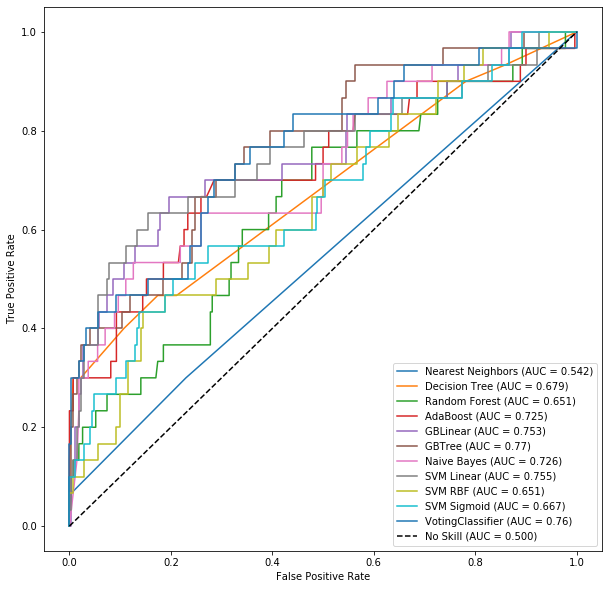

In [33]:
generate_roc_curves(fitted, names, X_test, Y_test)

In [34]:
def scores(Y_test, y_pred):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(Y_test, y_pred).ravel()
    print('{}, {}, {}, {}\n'.format(tn, fp, fn, tp))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    PPV = tp / (tp + fp)
    NPV = tn / (tn + fn)

    print('Sensitivity: {}'.format(sensitivity))
    print('Specificity: {}'.format(specificity))
    print('PPV: {}'.format(PPV))
    print('NPV: {}'.format(NPV))

    return None

curves = []

for model in fitted:
    y_pred = model.predict(X_test)
    print(model)
    print(classification_report(Y_test, y_pred))
    scores(Y_test, y_pred)
    curves.append(sklearn.metrics.roc_curve(Y_test, y_pred))
    print('\n')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       270
         1.0       0.67      0.07      0.12        30

    accuracy                           0.90       300
   macro avg       0.79      0.53      0.54       300
weighted avg       0.88      0.90      0.87       300

269, 1, 28, 2

Sensitivity: 0.06666666666666667
Specificity: 0.9962962962962963
PPV: 0.6666666666666666
NPV: 0.9057239057239057


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort